# Pictet case study
## GOAL
The goal is to investigate whether there is a correlation or not between stock prices and traded volumes and earthquakes for companies that doe fracking activities.
* Do earthquakes have an impact on stock prices and traded volumes? 
* Is this impact always positive or always negative?

## KPIs
* More than one company reflects correlation between earthquakes and stock prices or volume
* These companies behave in the same way, are affected the same way

# Data importing
## Step 1: updating the data

In [1]:
import re
import urllib2
import calendar
import datetime
import getopt
import sys
import time
import csv

In [439]:
crumble_link = 'https://finance.yahoo.com/quote/{0}/history?p={0}'
crumble_regex = r'CrumbStore":{"crumb":"(.*?)"}'
cookie_regex = r'set-cookie: (.*?); '
quote_link = 'https://query1.finance.yahoo.com/v7/finance/download/{}?period1={}&period2={}&interval=1d&events=history&crumb={}'
today = datetime.datetime.now().strftime("%Y-%m-%d")
yesterday = (datetime.datetime.now() - datetime.timedelta(1)).strftime("%Y-%m-%d")

In [440]:
def get_crumble_and_cookie(symbol):
    link = crumble_link.format(symbol)
    response = urllib2.urlopen(link)
    match = re.search(cookie_regex, str(response.info()))
    cookie_str = match.group(1)
    text = response.read()
    match = re.search(crumble_regex, text)
    crumble_str = match.group(1) if match!= None else ''
    return crumble_str, cookie_str


def download_quote(symbol, date_from, date_to):
    time_stamp_from = calendar.timegm(datetime.datetime.strptime(date_from, "%Y-%m-%d").timetuple())
    time_stamp_to = calendar.timegm(datetime.datetime.strptime(date_to, "%Y-%m-%d").timetuple())
    
    attempts = 0
    while attempts < 5:
        crumble_str, cookie_str = get_crumble_and_cookie(symbol)
        link = quote_link.format(symbol, time_stamp_from, time_stamp_to, crumble_str)
        #print link
        r = urllib2.Request(link, headers={'Cookie': cookie_str})

        try:
            response = urllib2.urlopen(r)
            text = response.read()
            print "{} downloaded".format(symbol)
            return text
        except urllib2.URLError:
            print "{} failed at attempt # {}".format(symbol, attempts)
            attempts += 1
            time.sleep(2*attempts)
    return ""

In [441]:
def update_cie_data(symbol):
    res = download_quote(symbol, yesterday, today)
    if res != "":
        bfr = map(lambda s: str.rsplit(s,','),str.rsplit(text,'\n'))
        with open('../data/%s_data.csv' % symbol, 'a') as newFile:
            newFileWriter = csv.writer(newFile)
            newFileWriter.writerow(bfr[1]) 

In [445]:
update_cie_data('SES')

SES failed at attempt # 0
SES downloaded


In [468]:
earthquake_url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&minmagnitude=3&minlatitude=24.6&maxlatitude=50&minlongitude=-125&maxlongitude=-65&starttime='

def update_eq_data():
    r = urllib2.Request(earthquake_url+yesterday)
    #[24.6, 50] Latitude
    #[-125, -65] Longitude
    try:
        response = urllib2.urlopen(r)
        text = response.read()
        bfr = map(lambda s: str.rsplit(s,','),str.rsplit(text,'\n'))
        with open('../data/earthquakes_data.csv', 'a') as newFile:
            newFileWriter = csv.writer(newFile)
            for row in bfr[1:]:
                if row != '':
                    newFileWriter.writerow(row)
    except urllib2.URLError:
        print "ERROR"

In [469]:
update_eq_data()

## Step 2: Importing all data into the notebook 

In [18]:
high_spn = []
volume_spn = []
close_spn = []
with open('../data/SPN_data.csv', 'rb') as csvfile:
    cr = csv.reader(csvfile, delimiter=',', quotechar=',')
    next(cr)
    for row in cr:
        if len(row)>1:
            high_spn.append((row[0],float(row[2])))
            close_spn.append((row[0],float(row[4])))
            volume_spn.append((row[0],float(row[6])))


In [55]:
high_clh = []
volume_clh = []
close_clh = []
with open('../data/CLH_data.csv', 'rb') as csvfile:
    cr = csv.reader(csvfile, delimiter=',', quotechar=',')
    next(cr)
    for row in cr:
        high_clh.append((row[0],float(row[2])))
        close_clh.append((row[0],float(row[4])))
        volume_clh.append((row[0],float(row[6])))

In [79]:
high_frac = []
volume_frac = []
close_frac = []
with open('../data/FRAC_data.csv', 'rb') as csvfile:
    cr = csv.reader(csvfile, delimiter=',', quotechar=',')
    next(cr)
    for row in cr:
        #print row
        high_frac.append((row[0],float(row[2])))
        close_frac.append((row[0],float(row[4])))
        volume_frac.append((row[0],float(row[6])))

In [80]:
high_wttr = []
volume_wttr = []
close_wttr = []
with open('../data/wttr_data.csv', 'rb') as csvfile:
    cr = csv.reader(csvfile, delimiter=',', quotechar=',')
    next(cr)
    for row in cr:
        if len(row)>1: 
            high_wttr.append((row[0],float(row[2])))
            close_wttr.append((row[0],float(row[4])))
            volume_wttr.append((row[0],float(row[6])))

In [81]:
high_slca = []
volume_slca = []
close_slca = []
with open('../data/SLCA_data.csv', 'rb') as csvfile:
    cr = csv.reader(csvfile, delimiter=',', quotechar=',')
    next(cr)
    for row in cr:
        if len(row)>1: 
            high_slca.append((row[0],float(row[2])))
            close_slca.append((row[0],float(row[4])))
            volume_slca.append((row[0],float(row[6])))

In [88]:
earthquake_days = []

with open('../data/earthquakes_data.csv', 'rb') as csvfile:
    cr = csv.reader(csvfile, delimiter=',', quotechar=',')
    next(cr)
    for row in cr:
        if(float(row[4])>= 3):
            earthquake_days.append(row[0])
print len(earthquake_days)

6310


Formating all dates the same

In [89]:
def remove_time(date):
    id = date.find('T')
    return date[:id]

In [90]:
earthquake_days = map(lambda x: remove_time(x) , earthquake_days)

**As first descpriptive approach**, we plot stock prices and traded volume time series and see if there is a visual pattern on earthquake days

In [128]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

In [86]:
high_time_serie = zip(*high_slca)
volume_time_serie = zip(*volume_slca)

In [91]:
dates_eq = pd.to_datetime(earthquake_days, format='%Y/%m/%d')
dates_slca = pd.to_datetime(high_time_serie[0], format='%Y/%m/%d')
dates_vol_slca = pd.to_datetime(volume_time_serie[0], format='%Y/%m/%d')

As traded volumes are too high comparatively to stock prices, we devide the volumes by a factor of 10k

In [92]:
volume_ts = map(lambda x: x/100000, volume_time_serie[1])
earth_ts = zip(*map(lambda x: (x,200),earthquake_days))

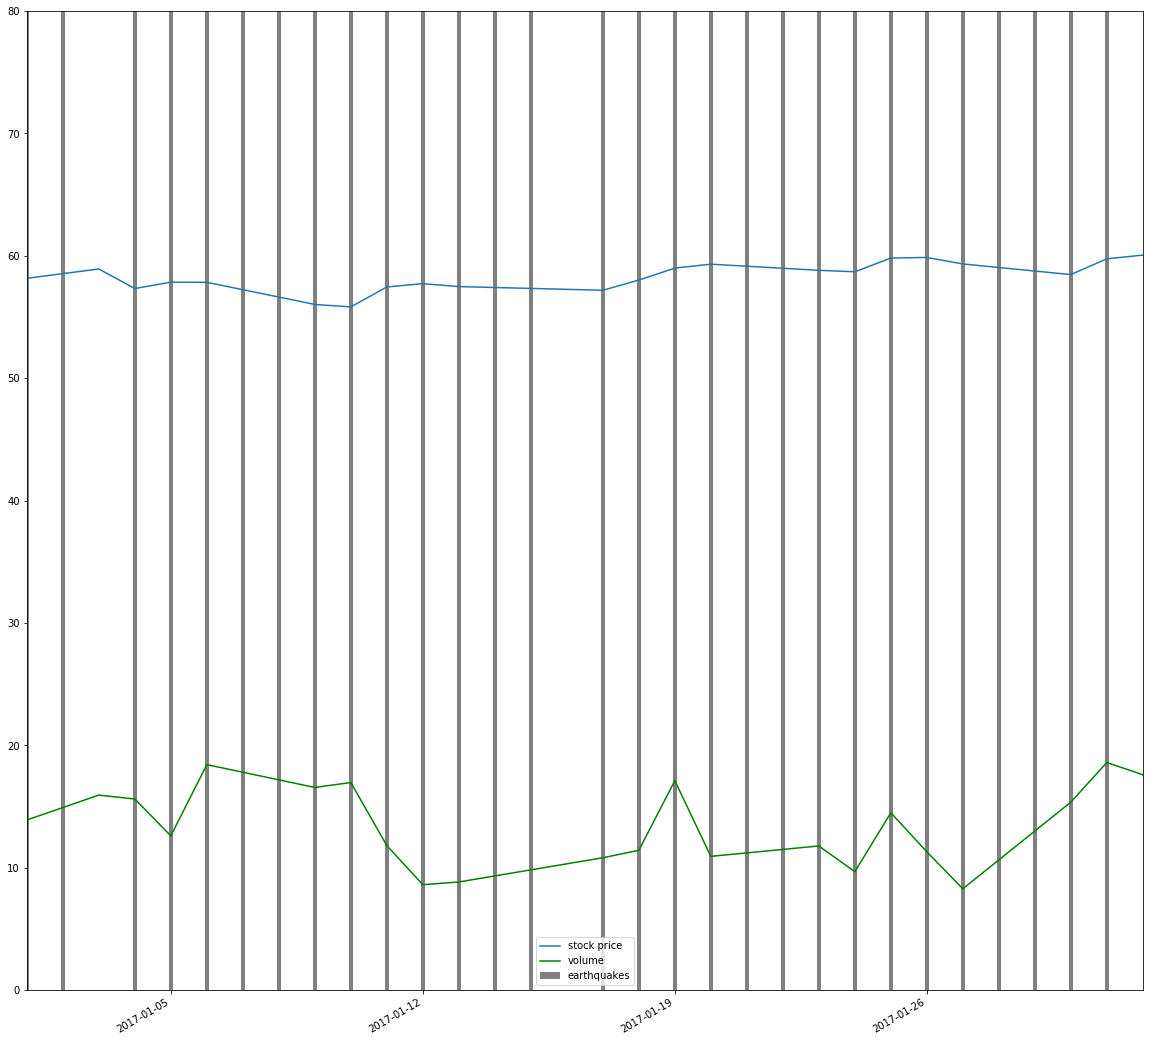

In [97]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111)
ax.bar(dates_eq[::-1], np.array(earth_ts[1]),width=0.1, color='grey',label='earthquakes')
ax.plot(dates_slca, np.array(high_time_serie[1]),label='stock price')
ax.plot(dates_vol_slca, np.array(volume_ts), color='green',label='volume')
fig.autofmt_xdate()
ax.set_xlim([datetime.date(2017, 1, 1), datetime.date(2017, 2, 1)])
ax.set_ylim([0, 80])
plt.legend()
plt.draw()

This graph over a month for the company SLCA doesn't show a consistant behaviour after eathquake events.
We can try with higher magnitude earthquakes to see if there is a significant impact only for high magnitude earthquakes

In [99]:
eq_days_high = []

with open('../data/earthquakes_data.csv', 'rb') as csvfile:
    cr = csv.reader(csvfile, delimiter=',', quotechar=',')
    next(cr)
    for row in cr:
        if(float(row[4])>= 4.5):
            eq_days_high.append(row[0])
print len(eq_days_high)

107


In [109]:
dates_eq_high[::-1]

DatetimeIndex(['2013-05-17 13:43:24.440000', '2013-05-24 03:47:08.180000',
               '2013-05-24 03:48:57.110000', '2013-05-24 08:02:19.490000',
               '2013-05-29 14:38:03.410000', '2013-06-07 03:17:54.150000',
               '2013-09-15 09:23:41.820000', '2013-09-21 12:16:12.170000',
               '2013-09-21 12:42:15.630000', '2013-09-21 13:16:33.080000',
               ...
               '2017-11-13 19:31:29.050000', '2018-01-19 16:17:44.720000',
               '2018-01-19 16:48:28.010000', '2018-01-20 13:48:54.420000',
               '2018-01-21 17:04:12.580000', '2018-03-19 23:36:41.530000',
               '2018-03-23 03:09:39.100000', '2018-04-05 19:29:16.500000',
               '2018-04-07 12:16:03.300000', '2018-04-09 10:22:20.050000'],
              dtype='datetime64[ns]', length=107, freq=None)

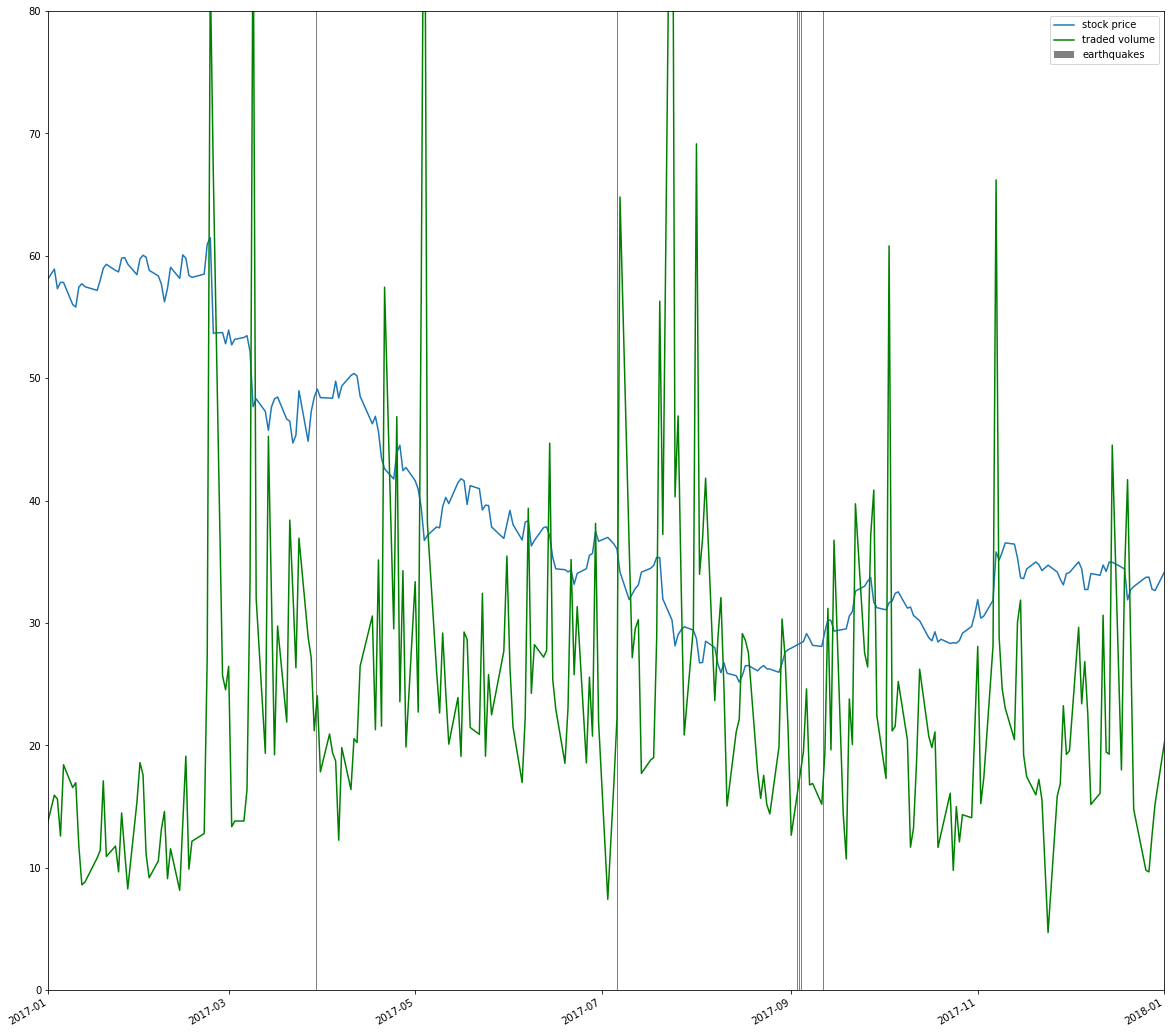

In [108]:
dates_eq_high = pd.to_datetime(eq_days_high, format='%Y/%m/%d')
earth_ts_high = zip(*map(lambda x: (x,200),map(remove_time,eq_days_high)))
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111)
ax.bar(dates_eq_high[::-1], np.array(earth_ts_high[1]),width=0.2, color='grey', label='earthquakes')
ax.plot(dates_slca, np.array(high_time_serie[1]),label='stock price')
ax.plot(dates_vol_slca, np.array(volume_ts), color='green',label='traded volume')
fig.autofmt_xdate()
ax.set_xlim([datetime.date(2017, 1, 1), datetime.date(2018, 1, 1)])
ax.set_ylim([0, 80])
plt.legend()
plt.draw()

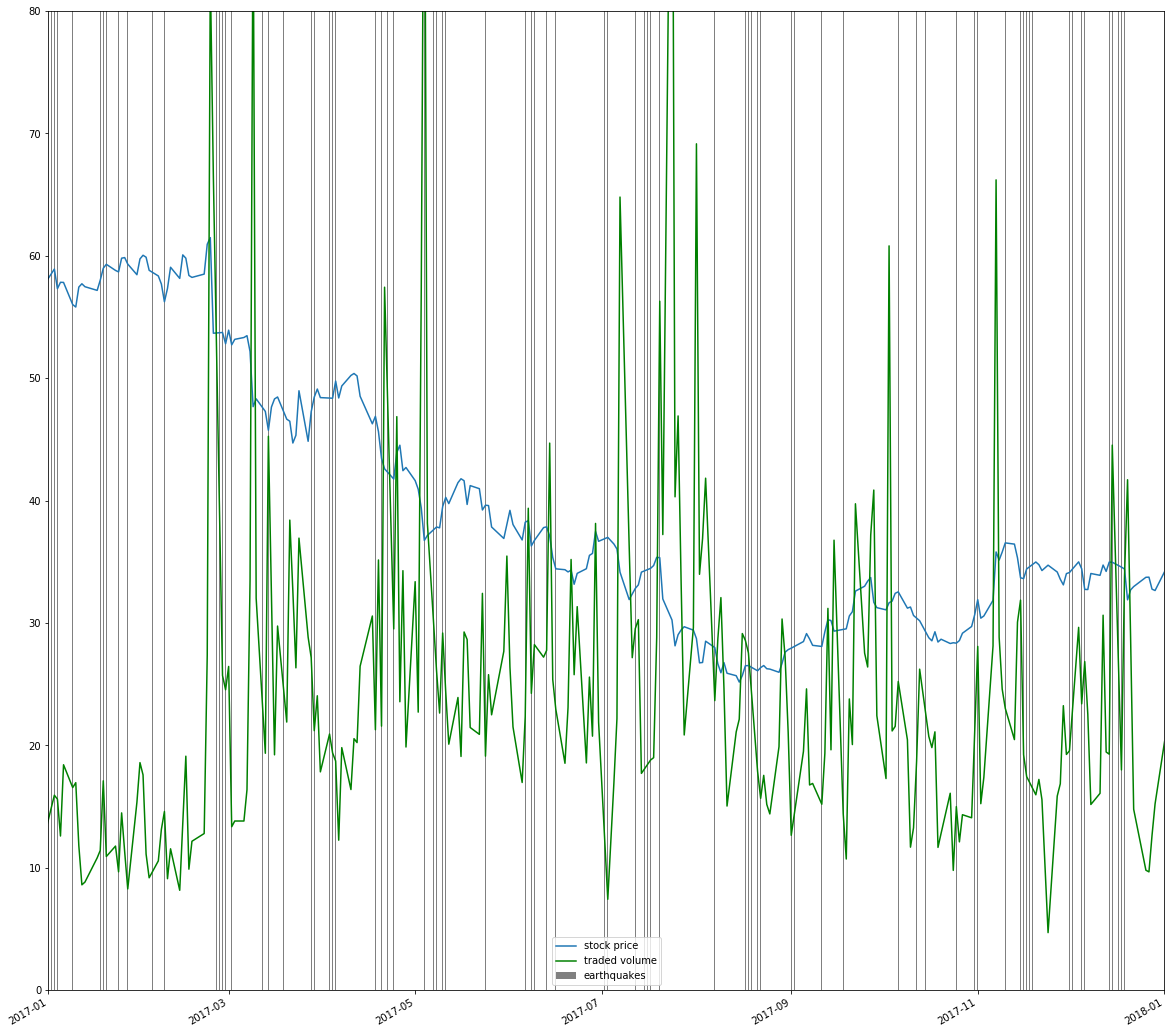

In [114]:
dates_eq_frack = pd.to_datetime(eq_fracking, format='%Y/%m/%d')
earth_ts_high = zip(*map(lambda x: (x,200),map(remove_time,eq_days_high)))
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111)
ax.bar(dates_eq_frack, np.full(len(dates_eq_frack),200),width=0.2, color='grey', label='earthquakes')
ax.plot(dates_slca, np.array(high_time_serie[1]),label='stock price')
ax.plot(dates_vol_slca, np.array(volume_ts), color='green',label='traded volume')
fig.autofmt_xdate()
ax.set_xlim([datetime.date(2017, 1, 1), datetime.date(2018, 1, 1)])
ax.set_ylim([0, 80])
plt.legend()
plt.draw()

In [113]:
len(np.array(earth_ts_high[1]))
len(dates_eq_high[::-1])

107

Similarly, we can see that the first earthquake on 2017 is followed by a big fall of traded volumes and a plateau for stock price. Whereas the following are followed by an increase of traded volumes and different stock prices behavior

In [98]:
plt.savefig('../data/slca_eq',format='jpg')

### Calculation of Stock returns 

In [115]:
def compute_stock_return(stock_price_high):
    stock_return=[]
    for i in range(1,len(stock_price_high)):
        stock_return.append((stock_price_high[i][0],(stock_price_high[i][1]-stock_price_high[i-1][1])/stock_price_high[i-1][1])) 
    return stock_return

In [116]:
stock_return_spn = compute_stock_return(high_spn)
sr_spn_eq = filter(lambda (x,y): x in earth_ts_high[0],stock_return_spn)

Text(0.5,1,u'SPN stock returns on high mag earthquake days distribution')

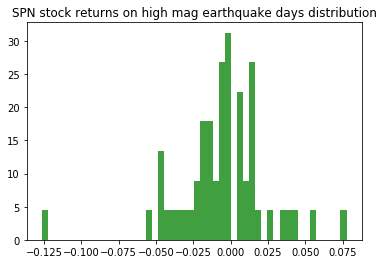

In [565]:
n, bins, patches = plt.hist(dict(sr_spn_eq).values(), 50, normed=1, facecolor='green', alpha=0.75)
plt.title(r'SPN stock returns on high mag earthquake days distribution')

SPN activity is not focused on the us what could explain poor correlation between earthquakes in US (where fracking is legal) and stock returns (close to gaussian distribution

Text(0.5,1,u'WTTR stock returns on earthquake days distribution')

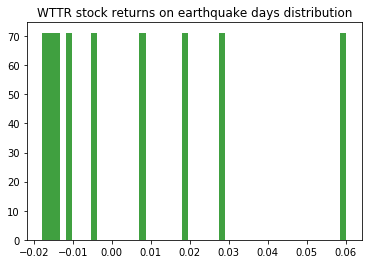

In [567]:
stock_return_wttr = compute_stock_return(high_wttr)
sr_wttr_eq = filter(lambda (x,y): x in earth_ts_high[0],stock_return_wttr)
n, bins, patches = plt.hist(dict(sr_wttr_eq).values(), 50, normed=1, facecolor='green', alpha=0.75)
plt.title(r'WTTR stock returns on earthquake days distribution')

Text(0.5,1,u'FRAC stock returns on earthquake days distribution')

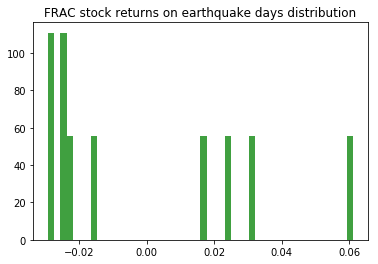

In [117]:
stock_return_frac = compute_stock_return(high_frac)
sr_frac_eq = filter(lambda (x,y): x in earth_ts_high[0],stock_return_frac)
n, bins, patches = plt.hist(dict(sr_frac_eq).values(), 50, normed=1, facecolor='green', alpha=0.75)
plt.title(r'FRAC stock returns on earthquake days distribution')

Text(0.5,1,u'CLH stock returns on earthquake days distribution')

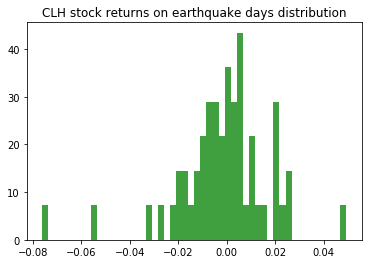

In [118]:
stock_return_clh = compute_stock_return(high_clh)
sr_clh_eq = filter(lambda (x,y): x in earth_ts_high[0],stock_return_clh)
n, bins, patches = plt.hist(dict(sr_clh_eq).values(), 50, normed=1, facecolor='green', alpha=0.75)
plt.title(r'CLH stock returns on earthquake days distribution')

Text(0.5,1,u'SLCA stock returns on earthquake days distribution')

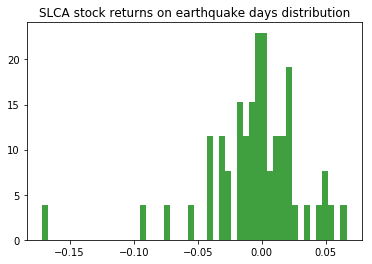

In [119]:
stock_return_slca = compute_stock_return(high_slca)
sr_slca_eq = filter(lambda (x,y): x in earth_ts_high[0],stock_return_slca)
n, bins, patches = plt.hist(dict(sr_slca_eq).values(), 50, normed=1, facecolor='green', alpha=0.75)
plt.title(r'SLCA stock returns on earthquake days distribution')

### Correlation of earthquakes with delayed stock returns 

Text(0.5,1,u'delayed SPN stock returns on high earthquake days distribution')

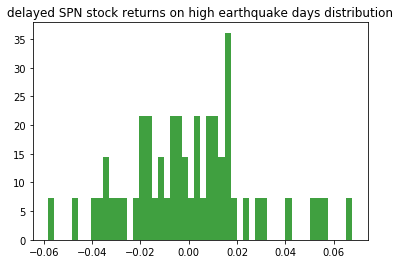

In [123]:
def delay_stock_return(stock_return,delay):
    delayed_stock = []
    for i in range(0,len(stock_return)-delay):
        delayed_stock.append([stock_return[i][0],stock_return[i+delay][1]])
    return delayed_stock

delayed_stock_spn = delay_stock_return(stock_return_spn,1)
delayed_sr_spn_eq = dict(filter(lambda (x,y): x in earth_ts_high[0],delayed_stock_spn))
n, bins, patches = plt.hist(delayed_sr_spn_eq.values(), 50, normed=1, facecolor='green', alpha=0.75)
plt.title(r'delayed SPN stock returns on high earthquake days distribution')

In [125]:
delayed_stock_slca = delay_stock_return(stock_return_slca,1)

Text(0.5,1,u'delayed SLCA stock returns on earthquake days distribution')

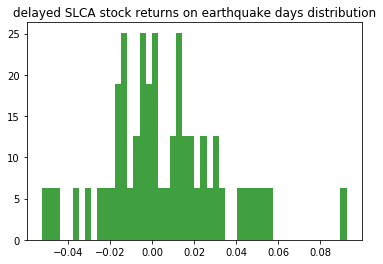

In [126]:
delayed_sr_slca_eq = dict(filter(lambda (x,y): x in earth_ts_high[0],delayed_stock_slca))
n, bins, patches = plt.hist(delayed_sr_slca_eq.values(), 50, normed=1, facecolor='green', alpha=0.75)
plt.title(r'delayed SLCA stock returns on earthquake days distribution')

## Linear regression: Ordinary Least Squares

In [137]:
def print_regression(stock_return):
    delayed_sr_all = dict(stock_return)
    delayed_df = pd.concat([pd.DataFrame(delayed_sr_all.keys()),pd.DataFrame(delayed_sr_all.values())], ignore_index=True, axis=1)
    delayed_df.columns=['Day', 'Returns']
    delayed_df['Day']=delayed_df['Day'].apply(lambda x: True if x in earth_ts_high[0] else False )
    correlation = sm.ols(formula="Returns ~ Day", data=delayed_df).fit()
    print correlation.summary()

#### Regression on SLCA stock returns

In [139]:
print_regression(stock_return_slca)

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.704
Date:                Sun, 22 Apr 2018   Prob (F-statistic):              0.192
Time:                        23:55:37   Log-Likelihood:                 2535.0
No. Observations:                1259   AIC:                            -5066.
Df Residuals:                    1257   BIC:                            -5056.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0009      0.001      0.985      

#### Regression SLCA stock return with 1 day delay

In [140]:
print_regression(delayed_stock_slca)

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.311
Date:                Sun, 22 Apr 2018   Prob (F-statistic):              0.252
Time:                        23:56:36   Log-Likelihood:                 2533.6
No. Observations:                1258   AIC:                            -5063.
Df Residuals:                    1256   BIC:                            -5053.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0005      0.001      0.517      

#### Explanations of summary
* Interpret representing the mean stock return when no earthquake = 0.0009 
* Stock returns in % are significantly more negative = 0,58 % less 
* Coefficient of determination R2=0.001. Thus, our model explains 0,1% of variance in stock returns which is very poor. We can't see a clear correlation between earthquakes and stock returns of SLCA

In [138]:
print_regression(stock_return_clh)

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4732
Date:                Sun, 22 Apr 2018   Prob (F-statistic):              0.492
Time:                        23:54:56   Log-Likelihood:                 3496.1
No. Observations:                1260   AIC:                            -6988.
Df Residuals:                    1258   BIC:                            -6978.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.383e-05      0.000      0.078      

In [582]:
print_regression(delay_stock_return(stock_return_clh,1))

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9190
Date:                Sun, 22 Apr 2018   Prob (F-statistic):              0.338
Time:                        13:22:35   Log-Likelihood:                 3492.0
No. Observations:                1258   AIC:                            -6980.
Df Residuals:                    1256   BIC:                            -6970.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -9.069e-05      0.000     -0.209      

Text(0.5,1,u'delayed CLH stock returns on earthquake days distribution')

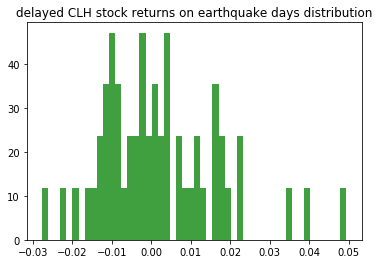

In [583]:
delayed_sr_clh_eq = dict(filter(lambda (x,y): x in earth_ts_high[0],delay_stock_return(stock_return_clh,1)))
n, bins, patches = plt.hist(delayed_sr_clh_eq.values(), 50, normed=1, facecolor='green', alpha=0.75)
plt.title(r'delayed CLH stock returns on earthquake days distribution')

0.0316 is the correlation between the observed durations, and the ones predicted (fitted) by our model. Both of these variables are numerical so we are able to correlate them

In [584]:
print_regression(stock_return_wttr)

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.2925
Date:                Sun, 22 Apr 2018   Prob (F-statistic):              0.589
Time:                        13:55:04   Log-Likelihood:                 435.06
No. Observations:                 201   AIC:                            -866.1
Df Residuals:                     199   BIC:                            -859.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0008      0.002      0.413      

In [586]:
print_regression(delay_stock_return(stock_return_wttr,1))

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.06757
Date:                Sun, 22 Apr 2018   Prob (F-statistic):              0.795
Time:                        13:56:44   Log-Likelihood:                 432.34
No. Observations:                 200   AIC:                            -860.7
Df Residuals:                     198   BIC:                            -854.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0011      0.002      0.556      

Text(0.5,1,u'delayed WTTR stock returns on earthquake days distribution')

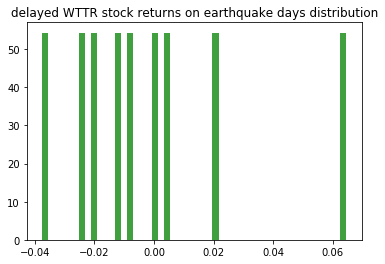

In [587]:
delayed_sr_wttr_eq = dict(filter(lambda (x,y): x in earth_ts_high[0],delay_stock_return(stock_return_wttr,1)))
n, bins, patches = plt.hist(delayed_sr_wttr_eq.values(), 50, normed=1, facecolor='green', alpha=0.75)
plt.title(r'delayed WTTR stock returns on earthquake days distribution')

## Better focus on earthquake data by keeping only fracking states

In [609]:
earthquake_url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&minmagnitude=3&minlatitude={}&maxlatitude={}&minlongitude={}&maxlongitude={}&starttime=2013-04-16'

In [611]:
def download_eq_data(minLat, maxLat, minLon, maxLon):
    link = earthquake_url.format(minLat, maxLat, minLon, maxLon)
    print link
    r = urllib2.Request(link)
    try:
        response = urllib2.urlopen(r)
        text = response.read()
        bfr = map(lambda s: str.rsplit(s,','),str.rsplit(text,'\n'))
        with open('../data/earthquakes_fracking_data.csv', 'a') as newFile:
            newFileWriter = csv.writer(newFile)
            for row in bfr[1:]:
                if row != '':
                    newFileWriter.writerow(row)
    except urllib2.URLError:
        print "ERROR"

In [623]:
fracking_states = [[31,35,85,89],[51.20,71.50,130,172],
                   [33,36,89,94],[32,42,114,124],
                   [37,41,102,109],[38.27,39.50,75,76],
                   [24,31,80,87],[37,42,87,91],
                   [37.46,41.46,84.47,88.6],[37,40,94.35,102.3],
                   [28.56,33.01,88.49,94.03],[41.41,48.18,82.7,90.25],
                   [30.12,35,88.06,91.39],[44.21,49,104.2,116.3],
                   [40,43,95.19,104.03],[35,42,114.2,120],
                   [31.20,37,103,109.3],[33.50,36.35,75.28,84.19],
                   [45.56,49,96.33,104.03],[38.24,41.59,80.31,84.49],
                   [33.37,37,94.26,103],[39.43,42.16,74.41,80.31],
                   [25.50,36.30,93.31,106.39],[37,42,109.3,114.3],
                   [36.32,39.28,75.15,83.41],[37.12,40.39,77.43,82.39],[41,45,104.3,111.3]]

In [624]:
for state in fracking_states:
    download_eq_data(state[0],state[1],state[2],state[3])

https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&minmagnitude=3&minlatitude=31&maxlatitude=35&minlongitude=85&maxlongitude=89&starttime=2013-04-16
https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&minmagnitude=3&minlatitude=51&maxlatitude=20&minlongitude=130&maxlongitude=172&starttime=2013-04-16
ERROR
https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&minmagnitude=3&minlatitude=33&maxlatitude=36&minlongitude=89&maxlongitude=94&starttime=2013-04-16
https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&minmagnitude=3&minlatitude=32&maxlatitude=42&minlongitude=114&maxlongitude=124&starttime=2013-04-16
https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&minmagnitude=3&minlatitude=37&maxlatitude=41&minlongitude=102&maxlongitude=109&starttime=2013-04-16
https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&minmagnitude=3&minlatitude=38.27&maxlatitude=39.5&minlongitude=75&maxlongitude=76&starttime=2013-04-16
https://earthquake.usgs.gov/fdsnws/

In [37]:
eq_fracking = []

with open('../data/earthquakes_fracking_data.csv', 'rb') as csvfile:
    cr = csv.reader(csvfile, delimiter=',', quotechar=',')
    for row in cr:
        if len(row) != 1:
            eq_fracking.append(remove_time(row[0]))
len(eq_fracking)

1588

Text(0.5,1,u'delayed CLH stock returns on earthquake days distribution')

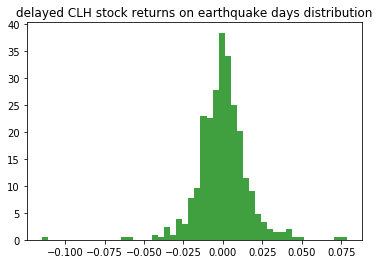

In [648]:
delayed_sr_clh_eq = dict(filter(lambda (x,y): x in eq_fracking,delay_stock_return(stock_return_clh,1)))
n, bins, patches = plt.hist(delayed_sr_clh_eq.values(), 50, normed=1, facecolor='green', alpha=0.75)
plt.title(r'delayed CLH stock returns on earthquake days distribution')

In [649]:
data = dict(filter(lambda (x,y): x in eq_fracking,delay_stock_return(stock_return_clh,1)))
print_regression(data)

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4508
Date:                Sun, 22 Apr 2018   Prob (F-statistic):              0.502
Time:                        19:27:02   Log-Likelihood:                 1479.1
No. Observations:                 539   AIC:                            -2954.
Df Residuals:                     537   BIC:                            -2946.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0001      0.001     -0.192      

## Calculation of historical volatility

In [57]:
sr_close_spn = dict(compute_stock_return(close_spn))
sr_close_slca = dict(compute_stock_return(close_slca))
sr_close_clh = dict(compute_stock_return(close_clh))
sr_close_wttr = dict(compute_stock_return(close_wttr))
sr_close_frac = dict(compute_stock_return(close_frac))

In [56]:
sr_close_spn_eq = dict(filter(lambda (x,y): x in eq_fracking,compute_stock_return(close_spn)))
sr_close_slca_eq = dict(filter(lambda (x,y): x in eq_fracking,compute_stock_return(close_slca)))
sr_close_clh_eq = dict(filter(lambda (x,y): x in eq_fracking,compute_stock_return(close_clh)))
sr_close_wttr_eq = dict(filter(lambda (x,y): x in eq_fracking,compute_stock_return(close_wttr)))
sr_close_frac_eq = dict(filter(lambda (x,y): x in eq_fracking,compute_stock_return(close_frac)))

In [64]:
print "SPN: Historical volatilty of data = ", np.std(sr_close_spn.values())
print " vs volatility on earthquake days = ", np.std(sr_close_spn_eq.values())
print "SLCA: Historical volatilty of data = ", np.std(sr_close_slca.values())
print " vs volatility on earthquake days = ", np.std(sr_close_slca_eq.values())
print "CLH: Historical volatilty of data = ", np.std(sr_close_clh.values())
print " vs volatility on earthquake days = ", np.std(sr_close_clh_eq.values())
print "WTTR: Historical volatilty of data = ", np.std(sr_close_wttr.values())
print " vs volatility on earthquake days = ",np.std(sr_close_wttr_eq.values())
print "FRAC: Historical volatilty of data = ",np.std(sr_close_frac.values())
print " vs volatility on earthquake days = ",np.std(sr_close_frac_eq.values())

SPN: Historical volatilty of data =  0.03187555958014223
 vs volatility on earthquake days =  0.03186119708991039
SLCA: Historical volatilty of data =  0.034831177532798276
 vs volatility on earthquake days =  0.033316425954141304
CLH: Historical volatilty of data =  0.016360205864305206
 vs volatility on earthquake days =  0.01607745706151567
WTTR: Historical volatilty of data =  nan
 vs volatility on earthquake days =  nan
FRAC: Historical volatilty of data =  0.02889902246773011
 vs volatility on earthquake days =  0.03427795951397348


In [77]:
sr_close_spn_eq = dict(filter(lambda (x,y): x in eq_fracking,delay_stock_return(compute_stock_return(close_spn),1)))
sr_close_slca_eq = dict(filter(lambda (x,y): x in eq_fracking,delay_stock_return(compute_stock_return(close_slca),1)))
sr_close_clh_eq = dict(filter(lambda (x,y): x in eq_fracking,delay_stock_return(compute_stock_return(close_clh),1)))
sr_close_wttr_eq = dict(filter(lambda (x,y): x in eq_fracking,delay_stock_return(compute_stock_return(close_wttr),1)))
sr_close_frac_eq = dict(filter(lambda (x,y): x in eq_fracking,delay_stock_return(compute_stock_return(close_frac),1)))

In [78]:
print "SPN: Historical volatilty of data = ", np.std(sr_close_spn.values())
print " vs volatility on earthquake days = ", np.std(sr_close_spn_eq.values())
print "SLCA: Historical volatilty of data = ", np.std(sr_close_slca.values())
print " vs volatility on earthquake days = ", np.std(sr_close_slca_eq.values())
print "CLH: Historical volatilty of data = ", np.std(sr_close_clh.values())
print " vs volatility on earthquake days = ", np.std(sr_close_clh_eq.values())
print "WTTR: Historical volatilty of data = ", np.std(sr_close_wttr.values())
print " vs volatility on earthquake days = ",np.std(sr_close_wttr_eq.values())
print "FRAC: Historical volatilty of data = ",np.std(sr_close_frac.values())
print " vs volatility on earthquake days = ",np.std(sr_close_frac_eq.values())

SPN: Historical volatilty of data =  0.03187555958014223
 vs volatility on earthquake days =  0.03240643739953548
SLCA: Historical volatilty of data =  0.034831177532798276
 vs volatility on earthquake days =  0.035015490216086846
CLH: Historical volatilty of data =  0.016360205864305206
 vs volatility on earthquake days =  0.017635284019536724
WTTR: Historical volatilty of data =  nan
 vs volatility on earthquake days =  0.019202804998662355
FRAC: Historical volatilty of data =  0.02889902246773011
 vs volatility on earthquake days =  0.030506879533101872


In [146]:
print_regression(sr_close_slca_eq)

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     5.207
Date:                Mon, 23 Apr 2018   Prob (F-statistic):             0.0229
Time:                        00:30:13   Log-Likelihood:                 1044.5
No. Observations:                 539   AIC:                            -2085.
Df Residuals:                     537   BIC:                            -2076.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0010      0.002      0.628      